# Data Exploration using Spectogram visualizations

In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from scipy import signal

from data import Read_Data

In [2]:
gd = Read_Data.GestureData()
features = gd.compile_data(nfft=4096, overlap=0.5, brange=8, keras_format=False, plot_spectogram=True, baseline_format=False)

In [3]:
from ipywidgets import interact
def make_plot(idx):
    plt.pcolormesh(features[idx]['features'])
    plt.title(str(features[idx]['user'])+' '+features[idx]['name'])
    plt.show()
    
interact(make_plot,idx=(0,len(features)-1,1),__manual=True)

<function __main__.make_plot>

In [4]:
len(features)

1246

# Class distribution

In [5]:
x, y, user, input_shape, lab_enc = gd.compile_data(nfft=4096, overlap=0.5,
                                                   brange=16, keras_format=True,
                                                   plot_spectogram=False,
                                                   baseline_format=False)


Input shape:(1246, 70, 32, 1)

Labels shape:(1246, 1)
Number of classes:  21


In [6]:
y = y.reshape(-1)

In [7]:
gesture_count=[]
for item in np.unique(user):
    idx = np.where(user==item)[0]
    y_user = y[idx]
    gesture_count.append(np.bincount(y_user))

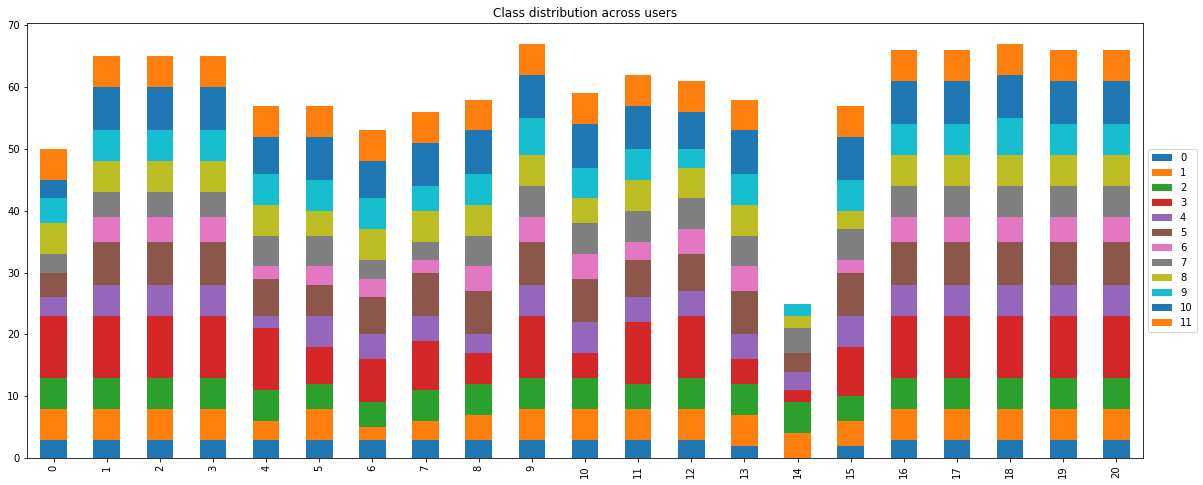

In [8]:
import pandas as pd
df = pd.DataFrame(gesture_count).T
df.plot(kind='bar', stacked=True, legend=False, figsize=(20, 8), title="Class distribution across users")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [9]:
from sklearn.model_selection import LeaveOneGroupOut, StratifiedShuffleSplit

def strat_shuffle_split(x, y, split=0.3, random_state=12345):
    cv_obj = StratifiedShuffleSplit(n_splits=1, test_size=split, random_state=random_state)
    for train_idx, test_idx in cv_obj.split(x, y):
        x_add_train, y_add_train = x[train_idx, :, :, :], y[train_idx]
        x_test, y_test = x[test_idx, :, :, :], y[test_idx]

    return x_add_train, x_test, y_add_train, y_test

logo = LeaveOneGroupOut()
for train_idx, test_idx in logo.split(x, y, user):
    print("\nUser: ", user[test_idx[0]])
    x_train, y_train = x[train_idx, :, :, :], y[train_idx]
    x_test, y_test = x[test_idx, :, :, :], y[test_idx]
    print("Training: ", x_train.shape)
    print("Testing: ", x_test.shape)
    for j in range(2):
        print("Fold:", j)
        seed_gen = j * 200
        # Split user test data - 60% added to the training data set
        x_add, x_test_new, y_add, y_test_new = strat_shuffle_split(x_test, y_test, split=0.4, random_state=seed_gen)
        
        # Add additional training data to the original
        x_train = np.vstack((x_train, x_add))
        y_train = np.vstack((y_train, y_add))
        
        sort_idx = np.argsort(y_test_new.reshape(-1))
        x_test_new = x_test_new[sort_idx, :, :, :]
        y_test_new = y_test_new[sort_idx]
        
        print("New Training: ", x_train.shape)
        print("New Testing: ", x_test_new.shape)


User:  1
Training:  (1188, 70, 32, 1)
Testing:  (58, 70, 32, 1)
Fold: 0


ValueError: all the input array dimensions except for the concatenation axis must match exactly